In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd

### resolve back index

In [2]:
n_series = [15, 20, 25, 30, 40, 50, 70, 100, 150, 200, 250, 300]
n_totals = [5000, 10000, 15000, 20000, 25000, 30000, 35000]
bs = [0.7, 1.0, 1.3]

all_permutations = [
    i
    for i in it.product(
        n_series,
        n_totals,
        bs,
    )
]
all_permutations = np.array(all_permutations)

# parameter vectors to run through with cl_idx
cl_n_series = all_permutations[:, 0].astype(int)
cl_n_totals = all_permutations[:, 1].astype(int)
cl_bs = all_permutations[:, 2]

def get_string_data(cutting, transform, cl_idx):
    if cutting == "constant_idx":
        save_str = (
            "results/distributions/cutting_" + str(cutting) + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    else:
        save_str = (
            "results/distributions/cutting_"
            + str(cutting)
            + "/transform_"
            + str(transform)
            + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    return save_str


def get_df(cutting, transform):
    all_acfs = []
    all_n_series = []
    all_n_series_used = []
    all_bs = []
    all_n_totals = []

    for cl_idx in range(len(cl_n_series)):

        save_str = get_string_data(cutting, transform, cl_idx)

        try :
            acfs = np.genfromtxt('../'+save_str, delimiter=',')
        except :
            acfs = []
        try :
            n_series_used = np.genfromtxt('../'+save_str.replace("acf_mean", "n_used_mean"), delimiter=',')
        except :
            n_series_used = []
        all_acfs.extend(acfs)
        all_n_series_used.extend(n_series_used)
        all_n_series.extend([cl_n_series[cl_idx]]*len(acfs))
        all_bs.extend([cl_bs[cl_idx]]*len(acfs))
        all_n_totals.extend([cl_n_totals[cl_idx]]*len(acfs))

    # make a dataframe
    df = pd.DataFrame({
        "acf": all_acfs,
        "n_series": all_n_series,
        "n_series_used": all_n_series_used,
        "b": all_bs,
        "n_total": all_n_totals,
    })
    return df

In [3]:
cutting = "random_idx"
transform = True

df = get_df(cutting, transform)

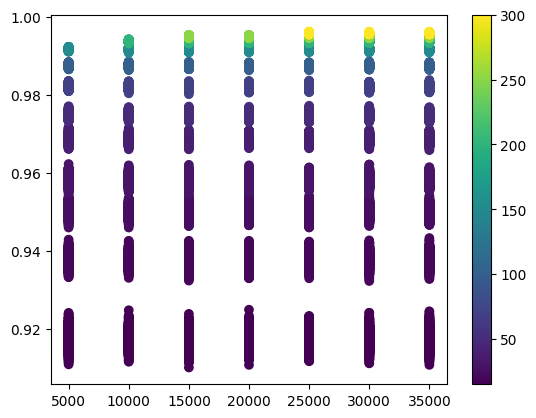

In [4]:
plt.scatter(df['n_total'], df['n_series_used']/ df['n_series'],c = df['n_series'])
plt.colorbar()

0.4554834807310068


Text(0, 0.5, 'std')

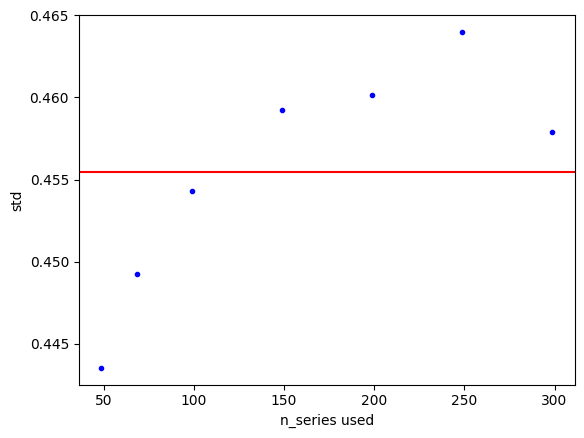

In [5]:
# get the mean value for each group
grouped_mean = df[df['n_series'] >= 50].groupby('n_series').mean()
grouped_std = df[df['n_series'] >= 50].groupby('n_series').std()

# estimate the std (which however, uses the n_series_used, the actual number of series used)
x = grouped_mean['n_series_used']
std = (x-2) / (x*np.sqrt(x-1))
normalized = grouped_std['acf'].values / std

# least squares
gamma = np.mean(normalized)
print(gamma)


plt.plot(x, normalized, color='blue', marker='o', linestyle='', markersize=3)
plt.axhline(y=gamma, color='red')

plt.xlabel("n_series used")
plt.ylabel("std")

In [79]:
# add new collum do df
x = df['n_series_used']
df['acf_th'] = -1/x

std = (x -2) / (x * np.sqrt(x-1))
df['acf_std_th'] = gamma * std


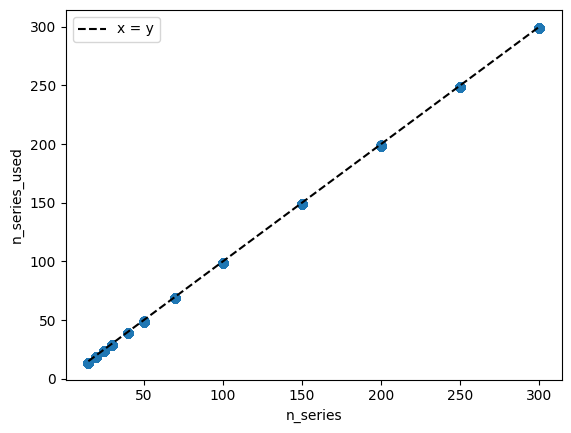

In [80]:
plt.plot(df["n_series"], df["n_series_used"], 'o')
plt.plot(df["n_series"], df["n_series"], 'k--', label ='x = y')
plt.xlabel("n_series")
plt.ylabel("n_series_used")
plt.legend()

In [81]:
# n_series_used
grouped_mean = df.groupby('n_series').mean()
grouped_std = df.groupby('n_series').std()

Text(0, 0.5, 'mean of MAC')

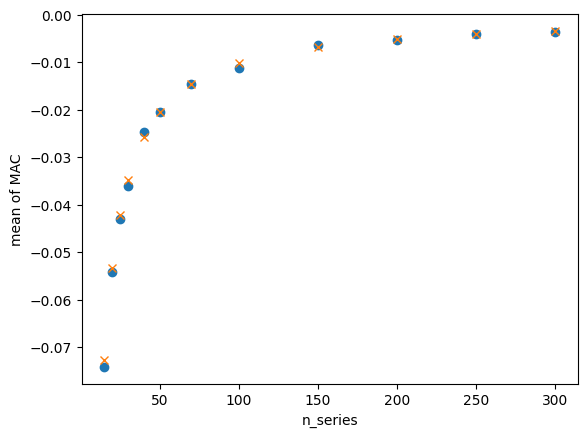

In [82]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("n_series")
plt.ylabel("mean of MAC")

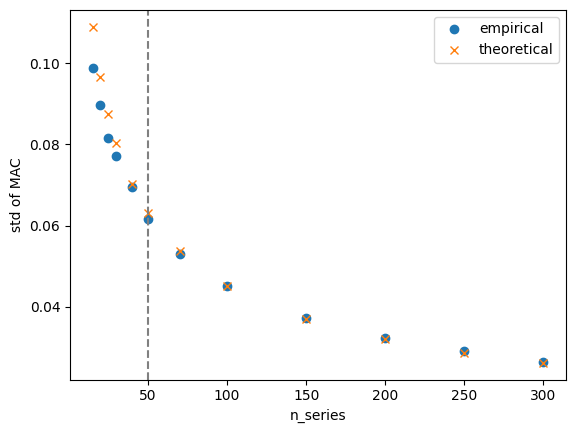

In [84]:
ax = plt.subplots(1,1)[1]

ax.plot(grouped_std.index, grouped_std['acf'], 'o', label='empirical')
ax.plot(grouped_std.index, grouped_mean['acf_std_th'], 'x', label='theoretical')

ax.axvline(x=50, color='grey', linestyle='--')

ax.set_xlabel("n_series")
ax.set_ylabel("std of MAC")

plt.legend()

In [22]:
# b
grouped_mean = df.groupby('b').mean()
grouped_std = df.groupby('b').std()

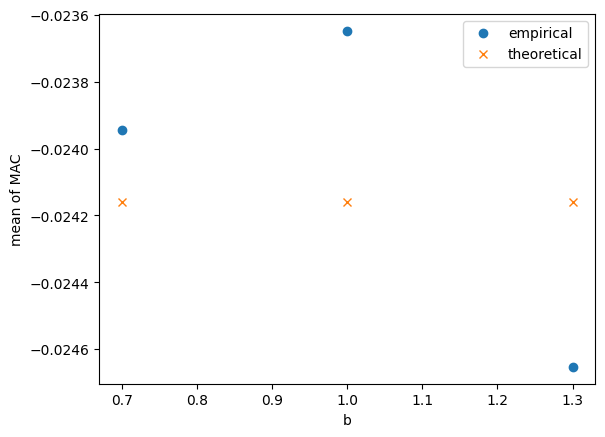

In [23]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("b")
plt.ylabel("mean of MAC")

plt.legend()

In [24]:
# n_series
grouped_mean = df.groupby('n_total').mean()
grouped_std = df.groupby('n_total').std()

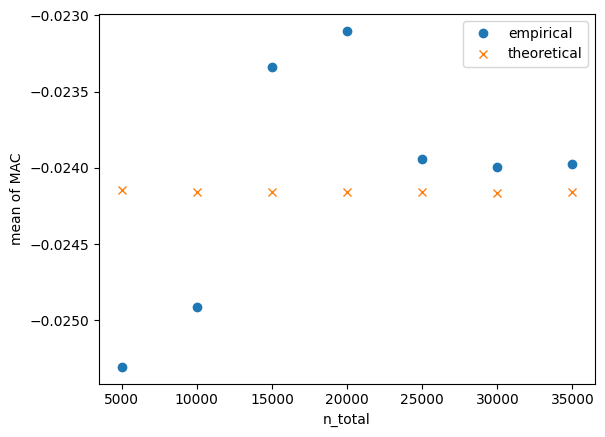

In [25]:
plt.plot(grouped_mean.index, grouped_mean['acf'], 'o', label='empirical')
plt.plot(grouped_mean.index, grouped_mean['acf_th'], 'x', label='theoretical')

plt.xlabel("n_total")
plt.ylabel("mean of MAC")

plt.legend()